# Preprocessing and filtering

I've been reading the filtering chapter of the computer vision book by Forsyth and Ponce (2012). While reading, I realize a few things that I have overlooked in this task:

- I did not remove the long wavelength variation (which I knew from the beginning), which is brighter in the middle of images and darker on the edge. This leads to inconsistent performance of the detection technique within the same image. 
- I did not realize that, in order to use correlation to find pattern, I have to apply normalized correlation. Otherwise, the correlation of an overall brighter region will be higher for sure, leading to false positives.
- The detected feature is not necessarily a peak on the correlation map. In some cases (e.g. the black cluster in our images), a bigger region correlates very well with the template, while finding a single peak in the big region remains challenging. In these cases, it is more appropriate to first label all the pixels as candidates, and then use matching scores and minimal distance to filter out patterns that do not match well. 

Based on these thoughts, let's get started to modify the algorithm. 

In [1]:
from skimage import io
import matplotlib.pyplot as plt
from bwtrack.bwtrack import find_black, find_white, show_result
import numpy as np
from myimagelib.myImageLib import to8bit, matlab_style_gauss2D, bestcolor
from scipy.signal import convolve2d
from myimagelib.xcorr_funcs import normxcorr2, FastPeakFind
import pandas as pd
from skimage.feature import peak_local_max
from skimage import io, measure, draw
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
import cv2
import os

## 1 Long wavelength illumination variation

This turns out to be difficult to remove.

## 2 Normalized correlation

Although I did not think about it, I used `normxcorr2` in both `find_black` and `find_white` implementations. I took another look at the `normxcorr2` code, and find that it does offset both template and image to zero mean, but whether it normalizes the two matrices is not clear to me. 

Here, I test this by computing the normxcorr on the same pattern, but different brightness.

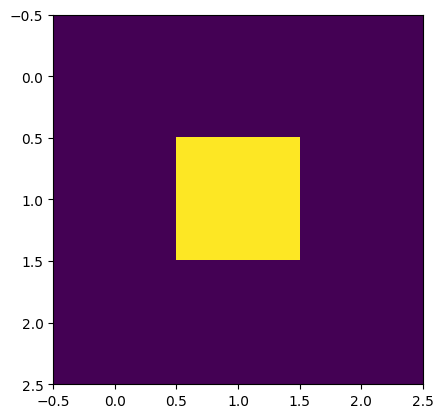

In [11]:
template = np.ones((3, 3))
template[1, 1] = 3
plt.imshow(template)

Now, construct the test image, by concatenate template with template * 10.

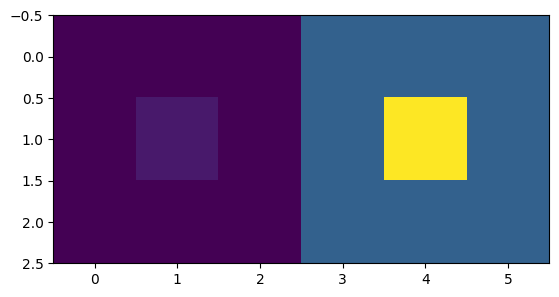

In [20]:
img = np.concatenate([template, template*10], axis=1)
plt.imshow(img)

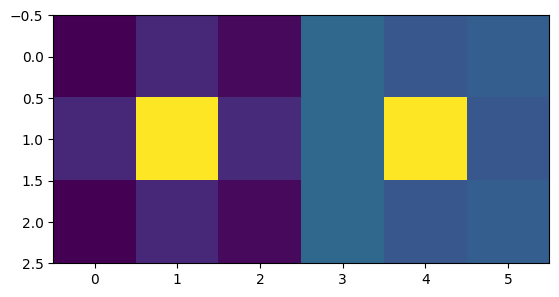

In [21]:
corr = normxcorr2(template, img, mode="same")
plt.imshow(corr)

We can see that the correlation value of the two peak are almost identical and are very close to 1, indicating that `normxcorr` computes the correct normalized correlation map.

## 3 Use correlation score instead of looking for peak

Sometimes, particle does not necessarily appear as a peak on the correlation map. This is especially true when image quality is low / features aggregate together. To maximize the chance of finding features, we keep all the points with good correlation score, and then use minimal distance criterion to filter out bad ones. 

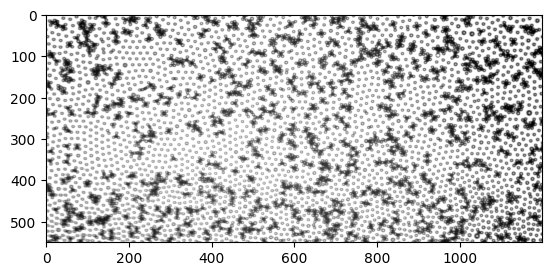

In [2]:
img = io.imread(r"..\..\test_images\2023-01-29_black.tif")
plt.imshow(img, cmap="gray")

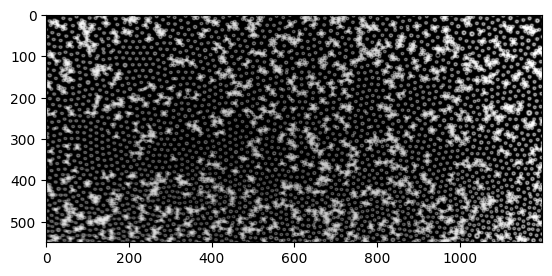

In [3]:
I = img#[:100, :100]
I = to8bit(I)
inv_img = 255 - I
plt.imshow(inv_img, cmap="gray")

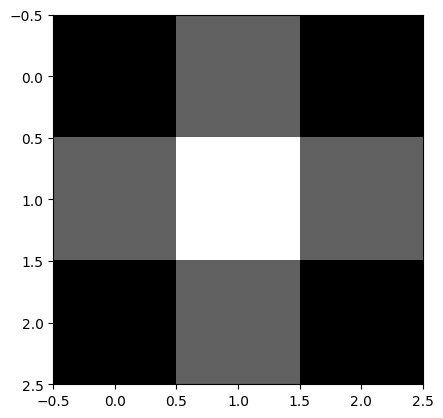

In [79]:
# blur with Gaussian filter
kernel = matlab_style_gauss2D(shape=(3, 3),sigma=1)
plt.imshow(kernel, cmap="gray")

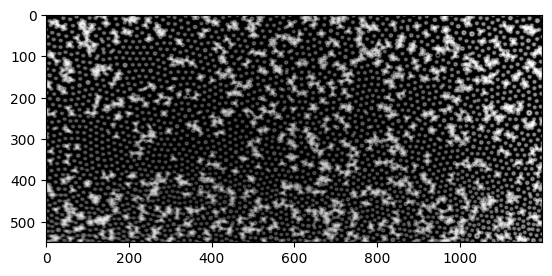

In [80]:
simg = convolve2d(inv_img, kernel, mode="same") 
plt.imshow(simg, cmap="gray")

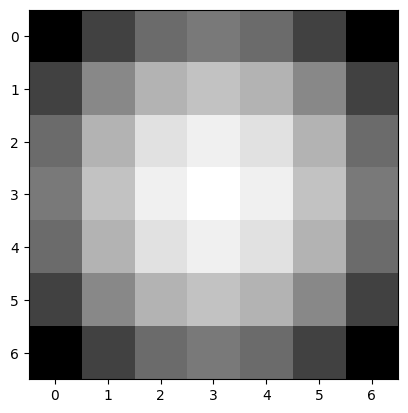

In [81]:
# Gaussian template
size = 7
gauss_shape = (size, size)
gauss_sigma = size 
gauss_mask = matlab_style_gauss2D(shape=gauss_shape,sigma=gauss_sigma)
plt.imshow(gauss_mask, cmap="gray")

C:\Users\liuzy\Documents\Github\mylib\src\myimagelib\xcorr_funcs.py:42: RuntimeWarning: divide by zero encountered in divide
  out = out / np.sqrt(image * template)


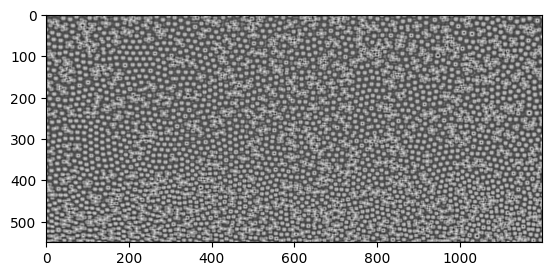

In [82]:
# correlation map
corr = normxcorr2(gauss_mask, simg, "same") # 找匹配mask的位置
plt.imshow(corr, cmap="gray")

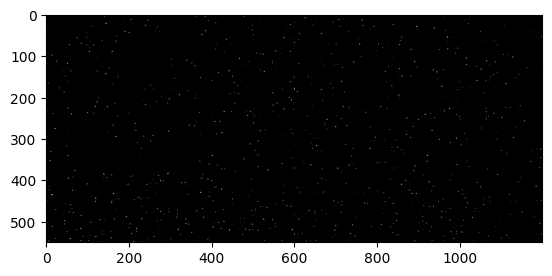

In [83]:
plt.imshow(corr>0.7, cmap="gray")

The threshold for correlation value turns out to be very arbitrary. This approach may be infeasible computationally. However, using different filters may result in better results. Let's try a bit.

In [106]:
# corr_sm = convolve2d(corr, matlab_style_gauss2D((3, 3), 3))
pcm = peak_local_max(corr, min_distance=5)

In [105]:
peak = FastPeakFind(corr) 

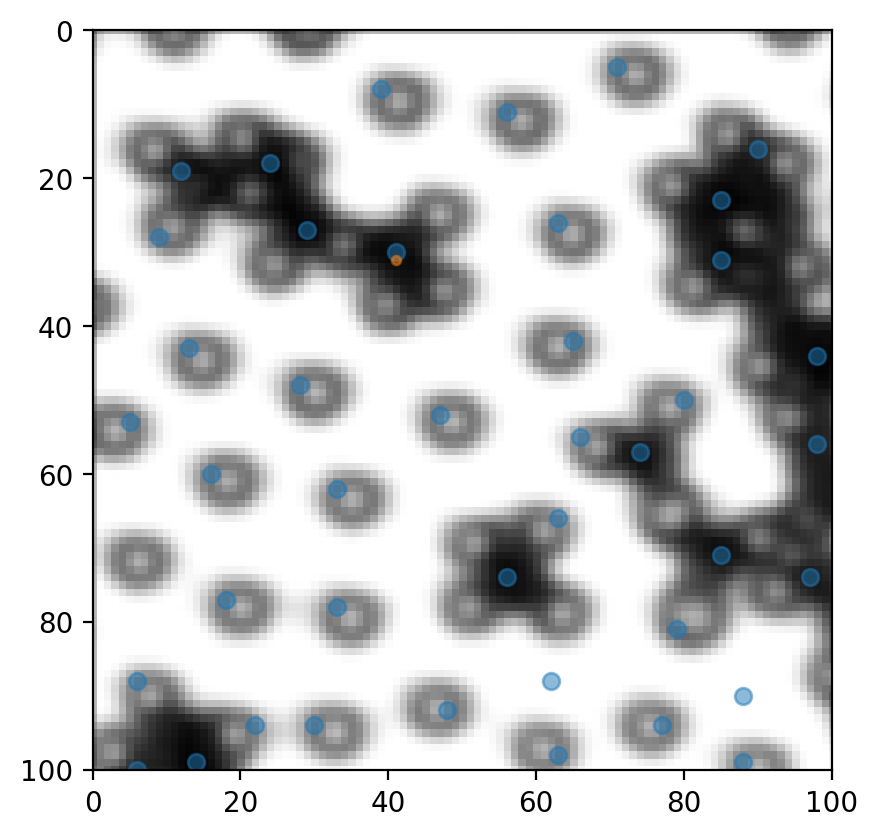

In [102]:
plt.figure(dpi=200)
plt.imshow(convolve2d(I, kernel, mode="same"), cmap="gray")
plt.scatter(pcm[:, 1], pcm[:, 0], alpha=0.5)
plt.xlim([0, 100])
plt.ylim([100, 0])
plt.scatter(peak[1, :], peak[0, :], s=10, alpha=0.5)

In [2]:
def find_black(img, size=7, thres=None, std_thres=None, plot_hist=False):
    """
    Find black particles in 乔哥's image. 
    
    :param img: raw image to find particles in 
    :type img: 2d array
    :param size: diameter of particle (px)
    :type size: int
    :param thres: threshold of mean intensity for discerning black and white particles. If None, the function will plot a histogram of mean intensity to help us.
    :type thres: int
    :param std_thres: threshold of standard deviation for discerning black and white particles. If None, the function will plot a histogram of standard deviation to help us.
    
    .. note::
    
       If ``thres=None`` or ``std_thres=None``, all detected features will be returned. Histograms of mean intensity and standard deviation will be plotted to help us set the threshold.

    :return: list of particle positions, pixel value sums and corr map peak values (x, y, pv, peak)
    :rtype: pandas.DataFrame
    
    .. rubric:: Edit
    
    * Nov 16, 2022 -- Initial commit.
    * Dec 09, 2022 -- Speed up by replacing the sum loop with ``regionprops``. Plot histograms to help setting threshold. Include distance check.
    * Feb 07, 2023 -- (i) use smaller kernel for smoothing
    """
    
    img = to8bit(img) # convert to 8-bit and saturate
    inv_img = 255 - img
    
    # generate gaussian template according to particle size
    gauss_shape = (size, size)
    gauss_sigma = size    
    gauss_mask = matlab_style_gauss2D(shape=gauss_shape,sigma=gauss_sigma) # 这里的shape是particle的直径，单位px
    

    timg = convolve2d(inv_img, matlab_style_gauss2D(), mode="same") 
    corr = normxcorr2(gauss_mask, timg, "same") # 找匹配mask的位置
    pcm = peak_local_max(corr, min_distance=size)
    # peak = FastPeakFind(corr) # 无差别找峰
    
    # apply min_dist criterion
    particles = pd.DataFrame({"x": pcm[:, 1], "y": pcm[:, 0]})
    # 加入corr map峰值，为后续去重合服务
    # particles["peak"] = corr[particles.y, particles.x]
    # particles = min_dist_criterion(particles, size-1)
    
    # 计算mask内的像素值的均值和标准差
    ## Create mask with feature regions as 1
    R = size // 2 
    mask = np.zeros(img.shape)
    for num, i in particles.iterrows():
        rr, cc = draw.disk((i.y, i.x), R) # 0.5 to avoid overlap
        mask[rr, cc] = 1
        
    ## generate labeled image and construct regionprops
    label_img = measure.label(mask)
    regions = measure.regionprops_table(label_img, intensity_image=img, properties=("label", "centroid", "intensity_mean", "image_intensity")) # use raw image for computing properties
    table = pd.DataFrame(regions)
    table["stdev"] = table["image_intensity"].map(np.std)
       
    if thres is not None and std_thres is not None:
        table = table.loc[(table["intensity_mean"] <= thres)&(table["stdev"] <= std_thres)]
    elif thres is None and std_thres is None:
        print("Threshold value(s) are missing, all detected features are returned.")        
    elif thres is not None and std_thres is None:
        print("Standard deviation threshold is not set, only apply mean intensity threshold")
        table = table.loc[table["intensity_mean"] <= thres]
    elif thres is None and std_thres is not None:
        print("Mean intensity threshold is not set, only apply standard deviation threshold")
        table = table.loc[table["stdev"] <= std_thres]
    
    if plot_hist == True:
        table.hist(column=["intensity_mean", "stdev"], bins=20)
        
    table = table.rename(columns={"centroid-0": "y", "centroid-1": "x"}).drop(columns=["image_intensity"])
    
    return table

In [7]:
img = io.imread(r"..\..\test_images\2023-01-29_black.tif")
black = find_black(img, thres=100, size=7)
white = find_white(img, size=7)

C:\Users\liuzy\Documents\Github\mylib\src\myimagelib\xcorr_funcs.py:42: RuntimeWarning: divide by zero encountered in divide
  out = out / np.sqrt(image * template)


Standard deviation threshold is not set, only apply mean intensity threshold


C:\Users\liuzy\Documents\Github\mylib\src\myimagelib\xcorr_funcs.py:42: RuntimeWarning: divide by zero encountered in divide
  out = out / np.sqrt(image * template)
C:\Users\liuzy\Documents\Github\mylib\src\myimagelib\xcorr_funcs.py:42: RuntimeWarning: invalid value encountered in divide
  out = out / np.sqrt(image * template)


Threshold value(s) are missing, all detected features are returned.


(<Figure size 640x480 with 1 Axes>, <AxesSubplot: >)

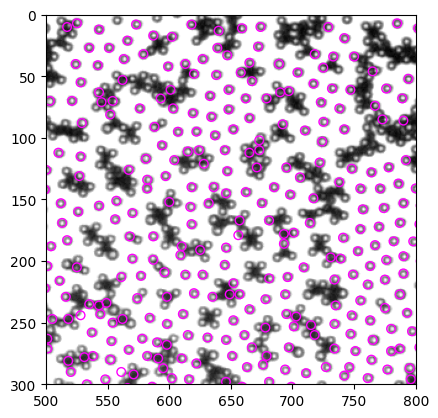

In [9]:
show_result(img, white, ROI=[500, 800, 300, 0])

In [23]:
img = io.imread(r"..\..\test_images\2023-01-29_black.tif")
black = find_black(img, thres=100, size=7)


C:\Users\liuzy\Documents\Github\mylib\src\myimagelib\xcorr_funcs.py:42: RuntimeWarning: divide by zero encountered in divide
  out = out / np.sqrt(image * template)


Standard deviation threshold is not set, only apply mean intensity threshold


In [26]:
white = find_white(img, size=7)

C:\Users\liuzy\Documents\Github\mylib\src\myimagelib\xcorr_funcs.py:42: RuntimeWarning: divide by zero encountered in divide
  out = out / np.sqrt(image * template)
C:\Users\liuzy\Documents\Github\mylib\src\myimagelib\xcorr_funcs.py:42: RuntimeWarning: invalid value encountered in divide
  out = out / np.sqrt(image * template)


Threshold value(s) are missing, all detected features are returned.


(<Figure size 640x480 with 1 Axes>, <AxesSubplot: >)

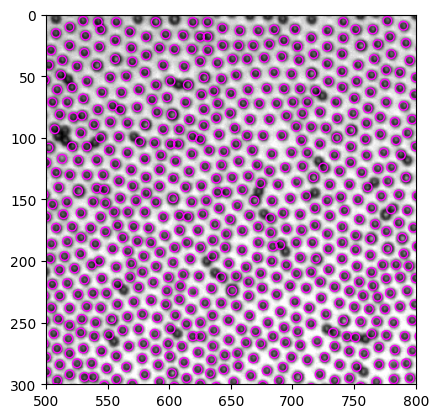

In [13]:
show_result(img, white, ROI=[500, 800, 300, 0])

In [19]:
def draw_particles(particles, size=7, ax=None, color="magenta"):
    if ax == None:
        ax = plt.gca()
    b_circ = [plt.Circle((xi, yi), radius=size/2, linewidth=1, fill=False, ec=color) for xi, yi in zip(particles.x, particles.y)]
    b = PatchCollection(b_circ, match_original=True)
    ax.add_collection(b)

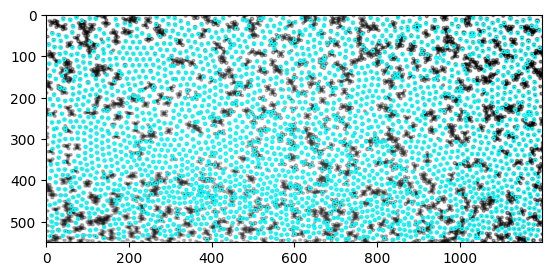

In [28]:
plt.imshow(img, cmap="gray")
draw_particles(white, color="cyan")
# plt.xlim([0, 100])
# plt.ylim([0, 100])

In [ ]:
def test(**kwargs):

    return a + b